In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sl

In [17]:
# read the data
df = pd.read_csv('./sim_2024-01-25_17-59-34_0ms_scanning.csv')

In [18]:
# access patterns
access_patterns = [
    "./request_maker/request_files/numReqs=64_recycleRatio=0.0_maxdistance=63.0_accessDensity=1.56_randomJampRatio_0.pkl",
    "./request_maker/request_files/numReqs=64_recycleRatio=0.0_maxdistance=62.0_accessDensity=3.12_randomJampRatio_5.pkl",
    "./request_maker/request_files/numReqs=64_recycleRatio=0.0_maxdistance=50.0_accessDensity=21.88_randomJampRatio_10.pkl",
    "./request_maker/request_files/numReqs=64_recycleRatio=1.56_maxdistance=29.0_accessDensity=54.69_randomJampRatio_25.pkl",
    "./request_maker/request_files/numReqs=64_recycleRatio=0.0_maxdistance=24.0_accessDensity=62.5_randomJampRatio_50.pkl",
]

2048


/tmp/ipykernel_104971/3931561940.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(categories, rotation=rotangle, fontsize=fig_size)


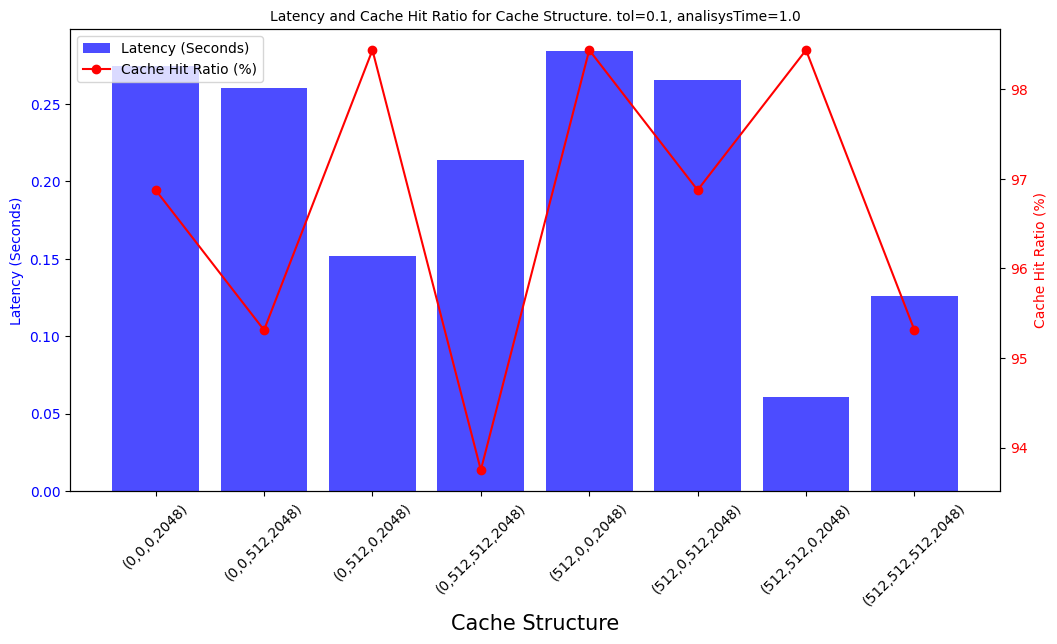

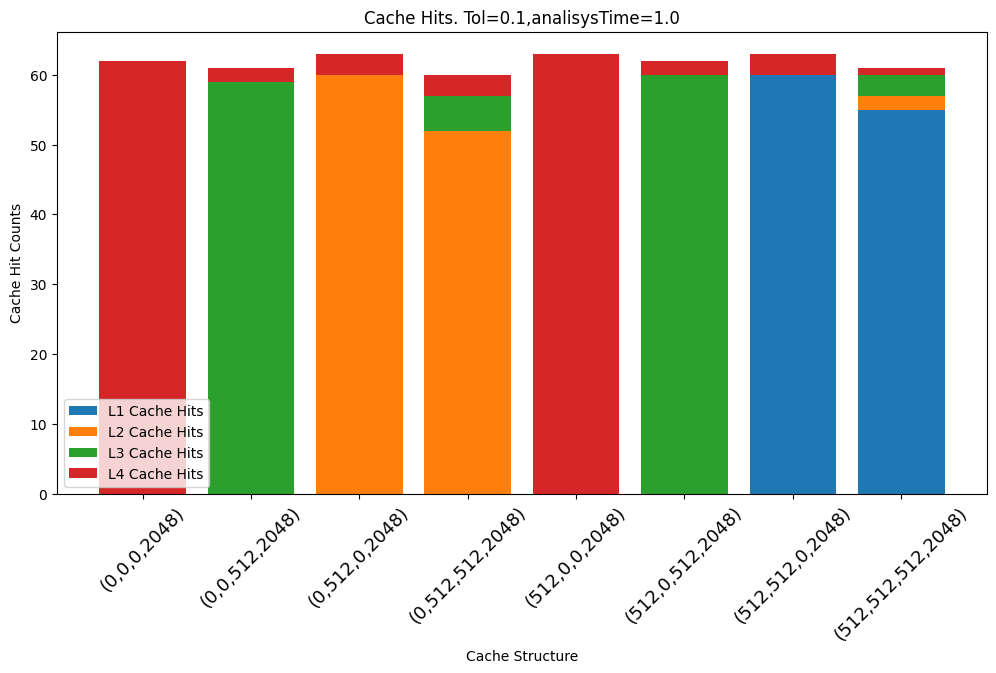

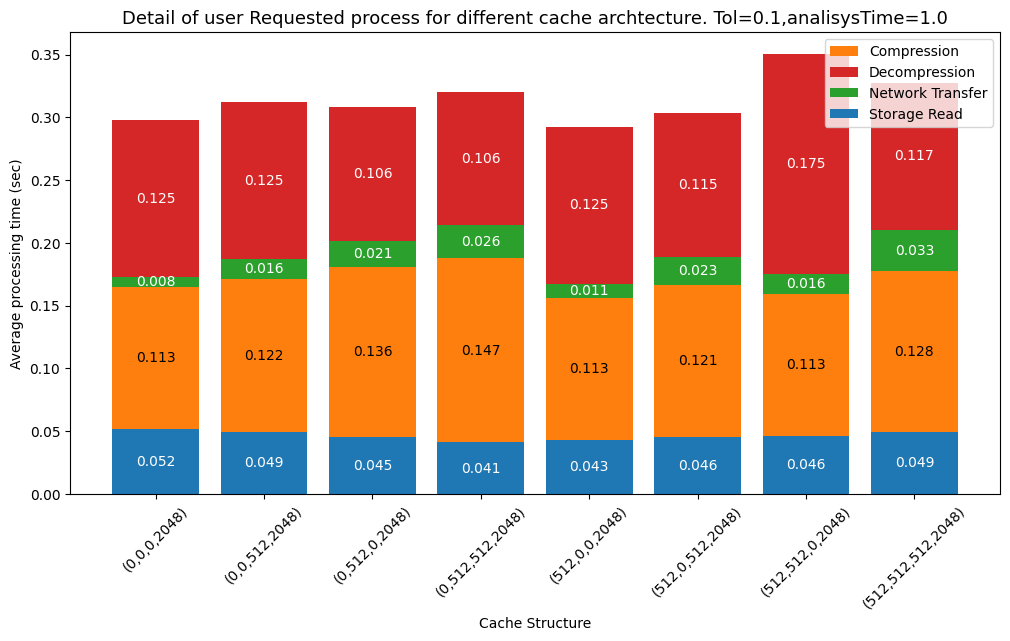

In [33]:
# 以上の、レイテンシー、キャッシュヒットの内訳、各処理の内訳のグラフ化をセットにして、外部ファイルとして
# 保存できるようにします。

# 固定する変数
tol = 0.1
Tclatency = 0
UserAnal = 1.0 # ユーザの処理時間
accessPattern = None
nReqs = 64


df_arch = df[(df["tol"] == 0.1) & (df["anlTime"] == UserAnal) & (df["nReqs"] == nReqs)]
df_arch = df_arch.drop(["nReqs","reqPatrn","blkSize"],axis=1)

# ここで、欲しいキャッシュ構成を持ってきてください
L1Sizes = [0,512]
L2Sizes = [0,512]
L3Sizes = [0,512]
L4Sizes = [0,2048]


hanrei = ["TileDB"]
latency = [[0.65]]
AllMissTime = [[64]]
HitUchiwake = []
UserReqLatUchiwake = []

# for TileDB
TileDBHitUchiwake = [[0,0,0,0]]
TileDBUserreq = [[0.04,0,0.60,0.01]]
                 
for L1size in L1Sizes:
    for L2size in L2Sizes:
        for L3size in L3Sizes:
            for L4size in L4Sizes:
                one_row = df_arch[(df_arch["L1Size"] == L1size) & (df_arch["L2Size"] == L2size) & (df_arch["L3Size"] == L3size) & (df_arch["L4Size"] == L4size)]
                hanrei.append(f"({L1size}, {L2size}, {L3size}, {L4size})")
                latency.append(one_row["AvrLat"].values)
                AllMissTime.append(one_row["nAllMis"].values) # nL1Hits,nL2Hits,nL3Hits,nL4Hits,nAllMis
                HitUchiwake.append([one_row["nL1Hits"].values,one_row["nL2Hits"].values,one_row["nL3Hits"].values,one_row["nL4Hits"].values])
                UserReqLatUchiwake.append([one_row["storageAvg"].values,one_row["compAvg"].values,one_row["networkAvg"].values,one_row["decompAvg"].values]) 

# 縦軸、平均レイテンシーの内訳の積み上げグラフ、横軸キャッシュ構成のグラフ ()
print(UserReqLatUchiwake)                
latency = [arr[0] for arr in latency]
AllMissTime = [arr[0] for arr in AllMissTime]
HitTimes = [nReqs - misstime for misstime in AllMissTime]
HitUchiwake = TileDBHitUchiwake + [[item[0] for item in sublist] for sublist in HitUchiwake]
UserReqLatUchiwake = TileDBUserreq + [[item[0] for item in sublist] for sublist in UserReqLatUchiwake]

print(HitUchiwake)
print(UserReqLatUchiwake)
print(UserReqLatUchiwake)
# rotation angle
rotangle = 30
figure_size = (15,6)
fontSize = 13

##### latency and cache hit ratio to multiple archtectures #####
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = hanrei
values = latency
cacheHitRatio = [HitTime/nReqs*100 for HitTime in HitTimes]

# Set the width and height of the figure
fig, ax1 = plt.subplots(figsize=figure_size)  # Adjust the values in figsize=(width, height)

# Create the first bar chart for latency
bars = ax1.bar(categories, latency, color='b', alpha=0.7, label='Latency (sec)')

# Label the first y-axis
# ax1.set_xlabel("Cache Structure")
ax1.set_ylabel("Latency (Seconds)", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis (twin) for cache hit ratio
ax2 = ax1.twinx()
ax2.plot(categories, cacheHitRatio, color='r', marker='o', label='Cache Hit Ratio (%)')

# Label the second y-axis
ax2.set_ylabel("Cache Hit Ratio (%)", color='r', fontsize=fontSize)
ax2.tick_params(axis='y', labelcolor='r')

# Add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left")

# Add a title
# plt.title(f"Latency and Cache Hit Ratio for Tolerance={tol}, User analysis time={UserAnal}", fontsize=13)
plt.title(f"Latency and Cache Hit Ratio", fontsize=fontSize)

# Set x-axis tick labels rotation and font size
ax1.set_xticklabels(categories, rotation=rotangle, fontsize=fontSize)

# Increase font size for x-axis labels
# ax1.set_xlabel("Cache Structure", fontsize=fontSize)
ax1.set_ylabel("Latency (Sec)", color='b', fontsize=fontSize)

# Annotate the bars with their values within the bars
for bar, value in zip(bars, latency):
    ax1.text(bar.get_x() + bar.get_width() / 2, value / 2,
             str(round(value, 3)), ha='center', va='center', fontsize=fontSize)

# Save the figure
file_name = f"tol={tol}_analTIme={UserAnal}_latency_{Tclatency}ms.png"
fig.savefig(file_name, bbox_inches='tight',format="png",dpi=300)


#############　キャッシュヒットの内訳 ################
# キャッシュヒットの内訳テスト
import matplotlib.pyplot as plt
import numpy as np

# Sample data
hanrei = hanrei
uchiwake = HitUchiwake

# Extract L1, L2, L3, L4 cache hit values separately
l1_hits = [item[0] for item in uchiwake]
l2_hits = [item[1] for item in uchiwake]
l3_hits = [item[2] for item in uchiwake]
l4_hits = [item[3] for item in uchiwake]

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=figure_size)

# Calculate the bottom positions for each category to stack the bars
bottom_l1 = np.zeros(len(hanrei))
bottom_l2 = np.add(bottom_l1, l1_hits)
bottom_l3 = np.add(bottom_l2, l2_hits)
bottom_l4 = np.add(bottom_l3, l3_hits)

# Define custom colors for each category
colors = ['tab:blue', 'tab:orange', 'tab:green','tab:red' ]


for i in range(len(hanrei)):
    ax.bar(hanrei[i], l1_hits[i], bottom=bottom_l1[i])
    ax.bar(hanrei[i], l2_hits[i], bottom=bottom_l2[i])
    ax.bar(hanrei[i], l3_hits[i], bottom=bottom_l3[i])
    ax.bar(hanrei[i], l4_hits[i], bottom=bottom_l4[i])
    
    total = l1_hits[i] + l2_hits[i] + l3_hits[i] + l4_hits[i]
    
    # Add count label on top of each bar
    ax.annotate(f"{total}", (hanrei[i], total + 1), ha='center', va='center', fontsize=10)

# Plot the stacked bars
ax.bar(hanrei, l1_hits, label='L1 Cache Hits', bottom=bottom_l1,color = colors[0])
ax.bar(hanrei, l2_hits, label='L2 Cache Hits', bottom=bottom_l2,color = colors[1])
ax.bar(hanrei, l3_hits, label='L3 Cache Hits', bottom=bottom_l3,color = colors[2])
ax.bar(hanrei, l4_hits, label='L4 Cache Hits', bottom=bottom_l4,color = colors[3])

# Label the axes and add a title
plt.xlabel("Cache Structure")
plt.ylabel("Cache Hit Counts",fontsize=fontSize)

# Rotate x-axis labels for better readability
plt.xticks(rotation=rotangle,fontsize=10)

# Add a legend
ax.legend()



file_name = f"tol={tol}_analTIme={UserAnal}_cachehitDetail_latency={Tclatency}ms.png"

# Show the chart
fig.savefig(file_name, bbox_inches='tight',format="png",dpi=300)


################ ユーザのリクエストに対する各プロセスの平均処理時間の内訳 ################



import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = hanrei
data = UserReqLatUchiwake

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(12,6))

# Extract StorageRead, Compression, NetworkLatency, and Decompression values separately
storage_read = [item[0] for item in data]
compression = [item[1] for item in data]
network_latency = [item[2] for item in data]
decompression = [item[3] for item in data]

# Calculate the bottom positions for each category to stack the bars
bottom_storage_read = np.zeros(len(categories))
bottom_compression = np.add(bottom_storage_read, storage_read)
bottom_network_latency = np.add(bottom_compression, compression)
bottom_decompression = np.add(bottom_network_latency, network_latency)

# Plot the stacked bars and add annotations for each segment
for i in range(len(categories)):
    ax.bar(categories[i], storage_read[i], bottom=bottom_storage_read[i], label='Storage Read', color='tab:blue')
    ax.annotate(f'{storage_read[i]:.3f}', (categories[i], bottom_storage_read[i] + storage_read[i] / 2),
                ha='center', va='center', fontsize=10, color='black')

    ax.bar(categories[i], compression[i], bottom=bottom_compression[i], label='Compression', color='tab:orange')
    ax.annotate(f'{compression[i]:.3f}', (categories[i], bottom_compression[i] + compression[i] / 2),
                ha='center', va='center', fontsize=10, color='black')

    ax.bar(categories[i], network_latency[i], bottom=bottom_network_latency[i], label='Network Transfer', color='tab:green')
    ax.annotate(f'{network_latency[i]:.3f}', (categories[i], bottom_network_latency[i] + network_latency[i] / 2),
                ha='center', va='center', fontsize=10, color='black')

    ax.bar(categories[i], decompression[i], bottom=bottom_decompression[i], label='Decompression', color='tab:red')
    ax.annotate(f'{decompression[i]:.3f}', (categories[i], bottom_decompression[i] + decompression[i] / 2),
                ha='center', va='center', fontsize=10, color='black')

# Label the axes and add a titl3
# plt.xlabel("Cache Structure",fontsize=13)
plt.ylabel("Average processing time (sec)",fontsize=13)
plt.title(f"Average processing time for a user Request",fontsize=13)

# Rotate x-axis labels for better readability
plt.xticks(rotation=rotangle,fontsize=13)

# Add a legend with only four labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))[:4]  # Keep only the first four unique labels
ax.legend([handles[labels.index(label)] for label in unique_labels], unique_labels, loc="upper right")


file_name = f"tol={tol}_analTIme={UserAnal}_eachProc_latency_{Tclatency}ms.png"

fig.tight_layout()
# Show the chart
fig.savefig(file_name,bbox_inches='tight',format="png",dpi=300)





/tmp/ipykernel_206804/1873037821.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(categories, rotation=rotangle, fontsize=15)


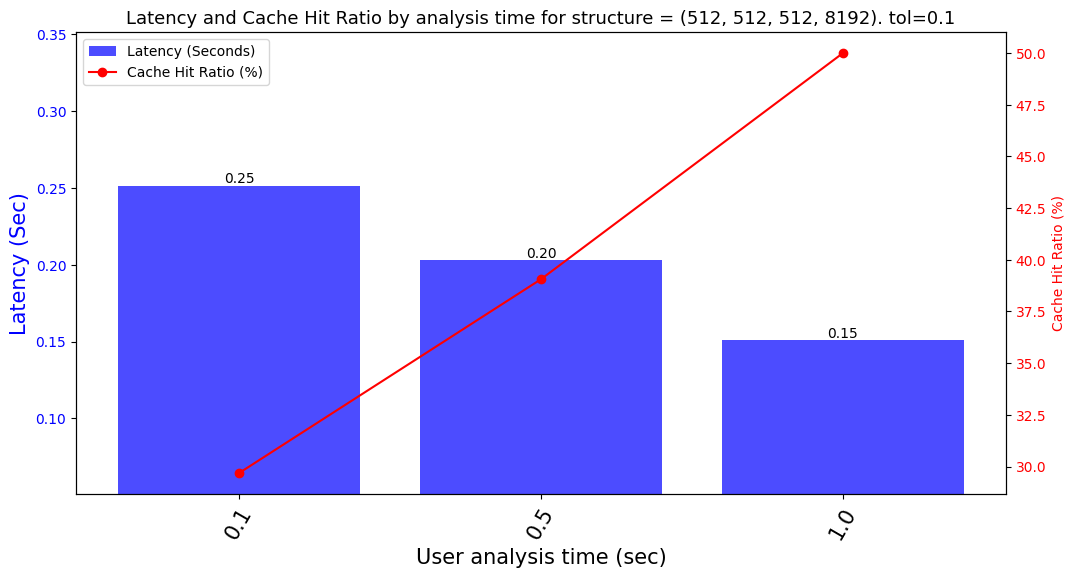

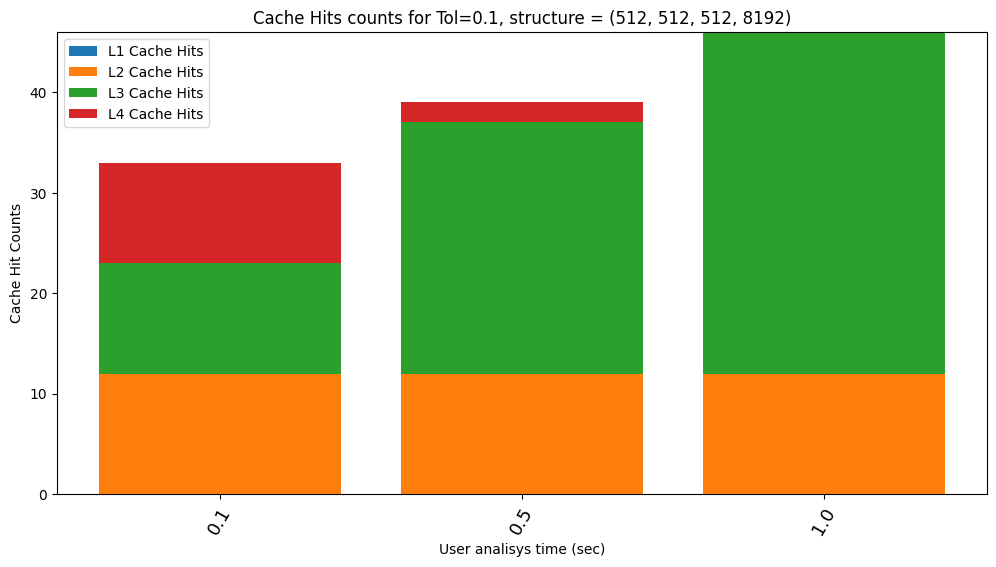

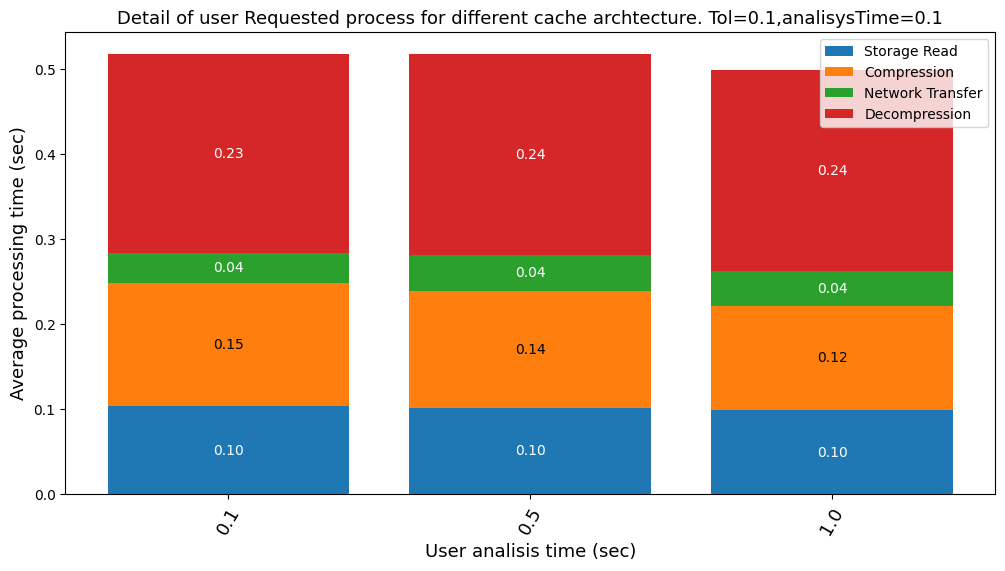

In [25]:
import matplotlib.pyplot as plt
import numpy as np

UserAnalTimes = [0.1, 0.5, 1.0]

# 固定する変数
tol = 0.1
accessPattern = None
nReqs = 64

# 例えば、L1=Off,L2=Off,L3=off,L4の変化を見たいとき
L1size = 512
L2size = 512
L3size = 512
L4size = 2048*4

cacheStruct = f"{L1size}_{L2size}_{L3size}_{L4size}"

df_arch = df[(df["tol"] == 0.1) & (df["nReqs"] == nReqs)]
df_arch = df_arch.drop(["nReqs", "reqPatrn", "blkSize"], axis=1)

latency = []
AllMissTime = []
HitUchiwake = []
UserReqLatUchiwake = []

for UseranalTime in UserAnalTimes:
    one_row = df_arch[(df_arch["anlTime"] == UseranalTime) & (df_arch["L1Size"] == L1size) & (df_arch["L2Size"] == L2size) & (df_arch["L3Size"] == L3size) & (df_arch["L4Size"] == L4size)]
    latency.append(one_row["AvrLat"].values)
    AllMissTime.append(one_row["nAllMis"].values)  # nL1Hits, nL2Hits, nL3Hits, nL4Hits, nAllMis
    HitUchiwake.append([one_row["nL1Hits"].values, one_row["nL2Hits"].values, one_row["nL3Hits"].values, one_row["nL4Hits"].values])
    UserReqLatUchiwake.append([one_row["storageAvg"].values, one_row["compAvg"].values, one_row["networkAvg"].values, one_row["decompAvg"].values])

# 縦軸、平均レイテンシーの内訳の積み上げグラフ、横軸キャッシュ構成のグラフ ()
latency = [arr[0] for arr in latency]
AllMissTime = [arr[0] for arr in AllMissTime]
HitTimes = [nReqs - misstime for misstime in AllMissTime]
HitUchiwake = [[item[0] for item in sublist] for sublist in HitUchiwake]
UserReqLatUchiwake = [[item[0] for item in sublist] for sublist in UserReqLatUchiwake]


# rotation angle
rotangle = 60

# Sample data
UserAnalTimes = [str(uanal) for uanal in UserAnalTimes]
categories = UserAnalTimes
values = latency
cacheHitRatio = [HitTime / nReqs * 100 for HitTime in HitTimes]

# Set the width and height of the figure
fig, ax1 = plt.subplots(figsize=(12, 6))  # Adjust the values in figsize=(width, height)

# Create the first bar chart for latency
bars = ax1.bar(categories, latency, color='b', alpha=0.7, label='Latency (Seconds)')

# Label the first y-axis
ax1.set_xlabel("Cache Structure")
ax1.set_ylabel("Latency (Seconds)", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis (twin) for cache hit ratio
ax2 = ax1.twinx()
ax2.plot(categories, cacheHitRatio, color='r', marker='o', label='Cache Hit Ratio (%)')

# Label the second y-axis
ax2.set_ylabel("Cache Hit Ratio (%)", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left")

# Add a title
plt.title(f"Latency and Cache Hit Ratio by analysis time for structure = ({L1size}, {L2size}, {L3size}, {L4size}). tol={tol}", fontsize=13)

# Set x-axis tick labels rotation and font size
ax1.set_xticklabels(categories, rotation=rotangle, fontsize=15)

# Increase font size for x-axis labels
ax1.set_xlabel("User analysis time (sec)", fontsize=15)
ax1.set_ylabel("Latency (Sec)", color='b', fontsize=15)

# Limit the y-axis between 0.3 and 0.5
ax1.set_ylim(min(latency) - 0.1, max(latency) + 0.1)

# Add numbers on top of the bars
for bar, value in zip(bars, latency):
    ax1.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2f}', ha='center', va='bottom')

# Save the figure
file_name = f"CacheStruct={cacheStruct}_tol={tol}_analTIme={UserAnal}.png"
plt.savefig(file_name)

# Show the plot
plt.show()


#### cache hitの内訳 ####
#############　キャッシュヒットの内訳 ################
# キャッシュヒットの内訳テスト
import matplotlib.pyplot as plt
import numpy as np

# Sample data
hanrei = UserAnalTimes
uchiwake = HitUchiwake

# Extract L1, L2, L3, L4 cache hit values separately
l1_hits = [item[0] for item in uchiwake]
l2_hits = [item[1] for item in uchiwake]
l3_hits = [item[2] for item in uchiwake]
l4_hits = [item[3] for item in uchiwake]

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate the bottom positions for each category to stack the bars
bottom_l1 = np.zeros(len(hanrei))
bottom_l2 = np.add(bottom_l1, l1_hits)
bottom_l3 = np.add(bottom_l2, l2_hits)
bottom_l4 = np.add(bottom_l3, l3_hits)

# Plot the stacked bars
ax.bar(hanrei, l1_hits, label='L1 Cache Hits', bottom=bottom_l1)
ax.bar(hanrei, l2_hits, label='L2 Cache Hits', bottom=bottom_l2)
ax.bar(hanrei, l3_hits, label='L3 Cache Hits', bottom=bottom_l3)
ax.bar(hanrei, l4_hits, label='L4 Cache Hits', bottom=bottom_l4)

# Label the axes and add a title
plt.xlabel("User analisys time (sec)")
plt.ylabel("Cache Hit Counts")
plt.title(f"Cache Hits counts for Tol={tol}, structure = ({L1size}, {L2size}, {L3size}, {L4size})")

# Rotate x-axis labels for better readability
plt.xticks(rotation=rotangle,fontsize=13)

# Add a legend
ax.legend()


file_name = f"CacheStruct={cacheStruct}_tol={tol}_analTIme={UserAnal}_cachehitDetail.png"

# Show the chart
plt.savefig(file_name)


############# ユーザのリクエストの各処理にかかった時間 ##################
################ ユーザのリクエストに対する各プロセスの平均処理時間の内訳 ################



import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = UserAnalTimes
data = UserReqLatUchiwake

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Extract StorageRead, Compression, NetworkLatency, and Decompression values separately
storage_read = [item[0] for item in data]
compression = [item[1] for item in data]
network_latency = [item[2] for item in data]
decompression = [item[3] for item in data]

# Calculate the bottom positions for each category to stack the bars
bottom_storage_read = np.zeros(len(categories))
bottom_compression = np.add(bottom_storage_read, storage_read)
bottom_network_latency = np.add(bottom_compression, compression)
bottom_decompression = np.add(bottom_network_latency, network_latency)

# Plot the stacked bars and add annotations for each segment
for i in range(len(categories)):
    ax.bar(categories[i], storage_read[i], bottom=bottom_storage_read[i], label='Storage Read', color='tab:blue')
    ax.annotate(f'{storage_read[i]:.2f}', (categories[i], bottom_storage_read[i] + storage_read[i] / 2),
                ha='center', va='center', fontsize=10, color='white')

    ax.bar(categories[i], compression[i], bottom=bottom_compression[i], label='Compression', color='tab:orange')
    ax.annotate(f'{compression[i]:.2f}', (categories[i], bottom_compression[i] + compression[i] / 2),
                ha='center', va='center', fontsize=10, color='black')

    ax.bar(categories[i], network_latency[i], bottom=bottom_network_latency[i], label='Network Transfer', color='tab:green')
    ax.annotate(f'{network_latency[i]:.2f}', (categories[i], bottom_network_latency[i] + network_latency[i] / 2),
                ha='center', va='center', fontsize=10, color='white')

    ax.bar(categories[i], decompression[i], bottom=bottom_decompression[i], label='Decompression', color='tab:red')
    ax.annotate(f'{decompression[i]:.2f}', (categories[i], bottom_decompression[i] + decompression[i] / 2),
                ha='center', va='center', fontsize=10, color='white')

# Label the axes and add a titl3
plt.xlabel("User analisis time (sec)",fontsize=13)
plt.ylabel("Average processing time (sec)",fontsize=13)
plt.title(f"Detail of user Requested process for different cache archtecture. Tol={tol},analisysTime={UserAnal}",fontsize=13)

# Rotate x-axis labels for better readability
plt.xticks(rotation=rotangle,fontsize=13)

# Add a legend with only four labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))[:4]  # Keep only the first four unique labels
ax.legend([handles[labels.index(label)] for label in unique_labels], unique_labels, loc="upper right")


file_name = f"CacheStruct={cacheStruct}_tol={tol}_analTIme={UserAnal}_eachProc.png"

# Show the chart
plt.savefig(file_name)

In [ ]:
# TODO
# tolを変化させたときの3セットをお願いします！！はーい！！！